In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# plt.rc('text.latex', preamble=r'\usepackage{wasysym}')


import scipy.integrate as si
import scipy as sp
import scipy.optimize as so
import scipy.interpolate as st #sinterp

Abs=np.abs
Log=np.log
Log10=np.log10
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
Cos=np.cos
Sin=np.sin
Arg=np.angle
HeavisideTheta=lambda x: np.heaviside(x,0)
def Plot(fun,xminmax,n=100):
    xlist=np.linspace(xminmax[0],xminmax[1],n)
    ylist=[fun(x) for x in xlist]
    plt.plot(xlist,ylist)
    
import time
def Timing_begin():
    global time_start
    time_start=time.time()
def Timing_end():
    Δt=time.time()-time_start
    print("time used:",Δt)
#     return Δt

In [2]:



MeV=1
GeV=1e3;
me=0.511*MeV
GF=0.00001166*GeV**-2
cm=5.06842e10 *MeV**-1
cmtoMeV = 5.06842e10



eV=1e-6 *MeV
kg=1e3*5.610e32* eV#;
kt=1e6*kg
atomic_u=9.315e2 #MeV


IBD_data=np.loadtxt("data/IBD-Strumia.txt")
IBD_data[:,1]=1e-41*cmtoMeV**2*IBD_data[:,1]
IBD_thre=1.8 * MeV
def σ_IBD(E):
    assert E>IBD_thre
    return np.interp(E,IBD_data[:,0],IBD_data[:,1])

In [3]:
N_SuperK_H=2* 32*kt/(18.015*atomic_u) 
bkg_SuperK=0.01  #unit: num of bkg events per second

N_HyperK_H=2* 374*kt/(18.015*atomic_u) 
bkg_HyperK=0.01 * 374/32  #unit: num of bkg events per second

N_THEIA_H=2* 100*kt/(18.015*atomic_u)  

N_DUNE_Ar=40*kt /(39.948*atomic_u) 
N_DUNE_e=(18)*40*kt /(39.948*atomic_u)
bkg_DUNE=0.01 * 40/32  #unit: num of bkg events per second

N_JUNO_H=2* 20*kt/(14*atomic_u)#assuming CnH2n->C1H2-> 12+2 p/n, 6+2 e
N_JUNO_e=(6+2) * 20*kt/(14*atomic_u) #assuming CnH2n->C1H2-> 12+2 p/n, 6+2 e
bkg_JUNO=0.01 * 20/32  #unit: num of bkg events per second

N_SuperK_e=(8+2) * 32*kt/(18*atomic_u) #assuming H2O->16+2 p or n, 8+2 e
N_HyperK_e=(8+2) * 374*kt/(18*atomic_u) #assuming H2O->16+2 p or n, 8+2 e
N_HyperK_H=2* 374*kt/(18*atomic_u)#



In [4]:
N_JUNO_H, N_THEIA_H, N_HyperK_H

(1.7207269381182426e+33, 6.686144083723395e+33, 2.502701735551977e+34)

In [5]:
#'data/flux-B16-GS98.npy' originally from the project of solar ν review
flux=np.load('data/flux-B16-GS98.npy',allow_pickle=True)
flux=flux.tolist()

In [6]:
def unity(Eν):
    return 1

In [7]:
def compute_N(Tlist=np.linspace(0.0,18.77,50),n_year=10,N_target=N_JUNO_H,
              R=unity, #R = branching ratio of .../ ..., Φnubar/Φnu
              P=unity # oscillation probability
             ):

    T_bin_widths=np.diff(Tlist)
    T_mid_list=Tlist[:-1]+T_bin_widths/2
    
    data=flux["8B"]
    Log10data=Log10(data)
    Emin,Emax=data[0,0],data[-1,0]
    ϕ= lambda E: 10**np.interp(Log10(E),Log10data[:,0],Log10data[:,1]) * HeavisideTheta(Emax-E)

    Eν_list=T_mid_list+IBD_thre
    ϕσPlist=[σ_IBD(Eν) * P(Eν)* R(Eν) * ϕ(Eν) *cm**-2 *MeV**-1  for T, Eν in zip(T_mid_list,Eν_list)]

    Nlist=np.array(ϕσPlist)*3600*24*365*n_year*N_target * T_bin_widths
        
    return T_mid_list,Nlist

[]

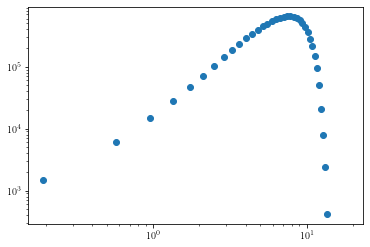

In [8]:
T_mid_list,Nlist=compute_N()

plt.errorbar(T_mid_list,Nlist,fmt='o')

# plt.yscale("log")
plt.loglog()

In [9]:
data=np.loadtxt("data/Energy_Spectrum.csv",delimiter=",",skiprows=1)
line1=np.loadtxt("data/Energy_Spectrum.csv",delimiter=",",max_rows=1,dtype=str)

Eν_list=1.*data[:,0]
mϕ_list=[float(mstr) for mstr in line1[2:]]
R_Eν_list=[data[:,2+mi]/data[:,1] for mi,m in enumerate(mϕ_list)]




data=np.loadtxt("result/Contact_S.csv",delimiter=",",skiprows=1)
Eν_list_S=1.*data[:,0]
R_Eν_list_S1=data[:,2]/data[:,1] # ν ν νbar νbar
R_Eν_list_S3=data[:,3]/data[:,1] # ν ν ν ν

data=np.loadtxt("result/Contact_VT.csv",delimiter=",",skiprows=1)
Eν_list_VT=1.*data[:,0]
R_Eν_list_V=data[:,2]/data[:,1] # 4ν vector
R_Eν_list_T=data[:,3]/data[:,1] # 4ν tensor

def R_Eν_fun(Eν,para):

    if para["case"]=="ϕνν":
        mi=para["mi"]
        return np.interp(Eν,Eν_list,R_Eν_list[mi])
    if para["case"]=="4νS1":
        return np.interp(Eν,Eν_list_S,R_Eν_list_S1)
    if para["case"]=="4νS3":
        return np.interp(Eν,Eν_list_S,R_Eν_list_S3)
    if para["case"]=="4νV":
        return np.interp(Eν,Eν_list_VT,R_Eν_list_V)
    if para["case"]=="4νT":
        return np.interp(Eν,Eν_list_VT,R_Eν_list_T)

    
R_Eν_fun(0.01,{"case":"ϕνν","mi":1})

12.161301841106877

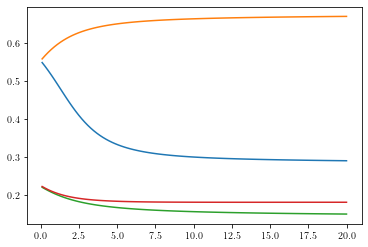

In [10]:
data=np.loadtxt("data/solarP_a_e.dat")
for i in [1,2,3,4]:
    plt.plot(data[:,0],data[:,i])
Eν_list_osc=1.*data[:,0]
Pα_list={"e":1.*data[:,2],"μ":1.* data[:,3],"τ":1.*data[:,4]}
def P_osc(Eν,α):
    return np.interp(Eν,Eν_list_osc,Pα_list[α])

# Effective four-fermion

new version: 

$\frac{1}{\Lambda^{4}}:\frac{1}{\left(1\text{MeV}\right)^{4}}=1:N_{tot}$
$\to$ $\frac{\left(1\text{MeV}\right)^{4}}{\Lambda^{4}}=\frac{1}{N_{tot}}$
$\to$ $N_{tot}^{1/4}\times1\text{MeV}=\Lambda$

In [11]:

for exp in ["JUNO","HK","THEIA"]:
    N_target={"JUNO":N_JUNO_H,"HK":N_HyperK_H,"THEIA":N_THEIA_H}[exp]
    for case in ["4νS1","4νS3","4νV","4νT"]:
        T_mid_list,Nlist=compute_N(N_target=N_target,R=lambda Eν:R_Eν_fun(Eν,{"case":case}) )
        N_tot=np.sum(Nlist)
        Λ=N_tot**0.25 *1 *MeV #see the equation above
        print(exp, case, "Λ=", Λ  )

JUNO 4νS1 Λ= 11.594441841148766
JUNO 4νS3 Λ= 17.161764646616913
JUNO 4νV Λ= 19.132043065660447
JUNO 4νT Λ= 44.98092235130016
HK 4νS1 Λ= 22.642487190809273
HK 4νS3 Λ= 33.514768671624665
HK 4νV Λ= 37.362474708425225
HK 4νT Λ= 87.84208607226843
THEIA 4νS1 Λ= 16.27855269981451
THEIA 4νS3 Λ= 24.09505296152207
THEIA 4νV Λ= 26.861316445105995
THEIA 4νT Λ= 63.15304565875989


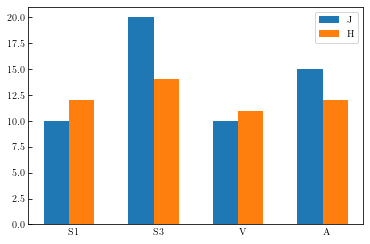

In [12]:
X=np.array([0,1,2,3])
plt.bar(X,[10,20,10,15],width=0.3,label="J")
plt.bar(X+0.3,[12,14,11,12],width=0.3,label="H")
ax=plt.gca()
ax.tick_params(axis="x",direction="in",which="both",length=0)
ax.tick_params(axis="y",direction="in",which="both")
plt.xticks(X+0.2, labels=["S1","S3","V","A"])
plt.legend()
plt.show()

In [13]:
for case in ["4νS1","4νS3","4νV","4νT"]:
    for α in ["e","μ","τ"]:
        for exp in ["JUNO","HK","THEIA"]:
            N_target={"JUNO":N_JUNO_H,"HK":N_HyperK_H,"THEIA":N_THEIA_H}[exp]
            T_mid_list,Nlist=compute_N(Tlist=np.linspace(0.0,18.77,50),N_target=N_target,
                                  R=lambda Eν:R_Eν_fun(Eν,{"case":case}),
                                      P=lambda Eν:P_osc(Eν,α)
                                      )
            N_tot=np.sum(Nlist)
            Λ=N_tot**0.25 *1 *MeV #see the equation above
            
#             print(exp, case, α, "Λ=", Λ  )


In [14]:
caseα_list=[]
caseαL_list=[]
labelSVT={"4νS1":r"$S'$","4νS3":r"$S$","4νV":r"$V$","4νT":r"$T$"}
labelα={"e":r"$e$","μ":r"$\mu$","τ":r"$\tau$"}
for case in ["4νS3","4νS1","4νV","4νT"]:    
    for α in ["e","μ","τ"]:
        caseα_list.append(case+α)
        caseαL_list.append(labelSVT[case]+"\n "+labelα[α])
        
# caseα_list

In [15]:
Geff1,Geff2=(90+170)**-2,(90-60)**-2
Geff3,Geff4=(4.6+0.5)**-2,(4.6-0.5)**-2

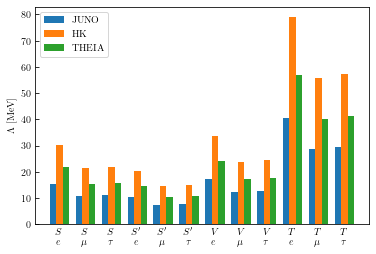

In [16]:
X=np.array(range(len(caseα_list)))

for iexp,exp in enumerate(["JUNO","HK","THEIA"]):
    
    Λ_list=[]
    for i,caseα in enumerate(caseα_list):    
        case,α=caseα[:-1],caseα[-1]
        N_target={"JUNO":N_JUNO_H,"HK":N_HyperK_H,"THEIA":N_THEIA_H}[exp]
        T_mid_list,Nlist=compute_N(Tlist=np.linspace(0.0,18.77,50),N_target=N_target,
                              R=lambda Eν:R_Eν_fun(Eν,{"case":case}),
                                  P=lambda Eν:P_osc(Eν,α)
                                  )
        N_tot=np.sum(Nlist)
        Λ=N_tot**0.25 *1 *MeV #see the equation above
        Λ_list.append(Λ)

    plt.bar(X+iexp*0.25,Λ_list,width=0.25,label=exp)
# plt.fill_between([0,12],y1=Geff3**-0.5,y2=Geff4**-0.5,color="C2")
# plt.fill_between([0,12],y1=Geff1**-0.5,y2=Geff2**-0.5,color="C2")
# plt.yscale("log")
# plt.ylim(0.1,500)
plt.ylabel(r"$\Lambda$ [MeV]")
ax=plt.gca()
ax.tick_params(axis="x",direction="in",which="both",length=0)
ax.tick_params(axis="y",direction="in",which="both")
plt.xticks(X+0.2, labels=caseαL_list)
plt.legend()
 
# plt.savefig('/home/xj/Dropbox/mywork/solar-vSI/git/lyx/fig/SVT_bound.pdf',bbox_inches='tight')    
plt.show()

# light mediator

In [17]:
def get_glist(exp):
    
    N_target={"JUNO":N_JUNO_H,"HK":N_HyperK_H,"THEIA":N_THEIA_H}[exp]
    g_list=[0]*len(mϕ_list)
    for mi,m in enumerate(mϕ_list):
#         T_mid_list,Nlist=compute_N(Tlist=np.linspace(0.0,18.77,50),N_target=N_target,
#                               R=lambda Eν:R_Eν_fun(Eν,mi))
        
        T_mid_list,Nlist=compute_N(N_target=N_target,
                      R=lambda Eν:R_Eν_fun(Eν,{"case":"ϕνν","mi":mi}),
                          P=lambda Eν:P_osc(Eν,"e")
                          )
        N_tot=np.sum(Nlist)
#         print (mi, g_list)
        g_list[mi]=1 / N_tot**0.5 
    return g_list


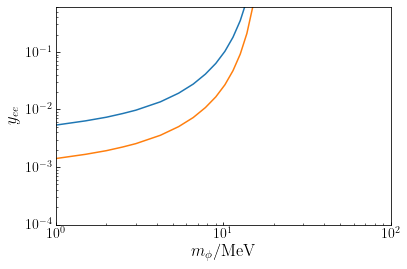

In [18]:
fig, ax = plt.subplots()
labelsize=14
ax.tick_params(axis="y",direction="in",which="both",labelsize=1.0*labelsize)
ax.tick_params(axis="x",direction="in",which="both",labelsize=1.0*labelsize)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.grid(which="both")
plt.xlim(1e0,1e2)
plt.ylim(1e-4,6e-1)

ax.set_xlabel(r'$m_{\phi}/{\rm MeV}$',fontsize=1.2*labelsize)
ax.set_ylabel(r'$y_{ee}$',fontsize=1.2*labelsize)



for exp in ["JUNO","HK"]:
    plt.plot(mϕ_list,get_glist(exp))



plt.show()

In [19]:
K_e=10**np.loadtxt(r"data/meson-bounds/K_e.csv",delimiter=",");
pi_e=10**np.loadtxt(r"data/meson-bounds/pi_e.csv",delimiter=",");
D_e=10**np.loadtxt(r"data/meson-bounds/D_e.csv",delimiter=",");
Z_e=10**np.loadtxt(r"data/meson-bounds/Z_e.csv",delimiter=",");
D_mu=10**np.loadtxt(r"data/meson-bounds/D_mu.csv",delimiter=",");
K_mu=10**np.loadtxt(r"data/meson-bounds/K_mu.csv",delimiter=",");


MSI=np.array([
[2.9286445646252375e-6, 0.0001],
[0.03408083981649994, 1], 
[0.29258707953277385, 1.0], 
[0.00002782559402207126, 0.0001]
])
MSI[:,0]=1e3*MSI[:,0]





def generate_Z_inv_bound(a=2.9963+0.0074*3-3):
    #imported from the Z_inv project
    mlist=np.logspace(0,4.8);#from 1MeV to 1000MeV
    def Nnu(tr,m,mz):
    #     return (tr*Log(mz/m))/(8.*Pi**2) + (tr*((-17 - m**6/mz**6 + (9*m**4)/mz**4 \
    #     + (9*m**2)/mz**2)/12. + (1 + (3*m**3)/mz**3)*Log(mz/m)))/(8.*Pi**3)
        return (tr*(Log(mz/m)+3.0/4.0))/(8.*Pi**2) + (tr*((-17 - m**6/mz**6 + (9*m**4)/mz**4 \
        + (9*m**2)/mz**2)/12. + (1 + (3*m**3)/mz**3)*Log(mz/m)))/(8.*Pi**2)

    Nnulist = np.array([Nnu(1.0, m,91.19e3) for m in mlist])

    # a=2.984+0.008*3-3

    trlist=a/Nnulist
    return np.transpose([mlist,np.sqrt(trlist)])
z_inv_bound=generate_Z_inv_bound()

In [20]:
Geff1,Geff2=(90+170)**-2,(90-60)**-2
Geff3,Geff4=(4.6+0.5)**-2,(4.6-0.5)**-2

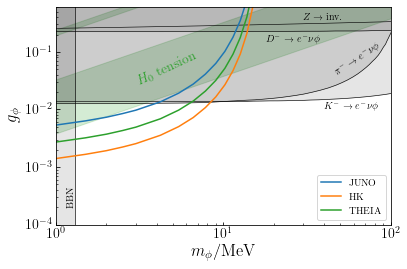

In [21]:
fig, ax = plt.subplots()
labelsize=14
ax.tick_params(axis="y",direction="in",which="both",labelsize=1.0*labelsize)
ax.tick_params(axis="x",direction="in",which="both",labelsize=1.0*labelsize)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.grid(which="both")
plt.xlim(1e0,1e2)
plt.ylim(1e-4,6e-1)

ax.set_xlabel(r'$m_{\phi}/{\rm MeV}$',fontsize=1.2*labelsize)
ax.set_ylabel(r'$g_{\phi}$',fontsize=1.2*labelsize)



m_list=np.geomspace(1,100)        
ax.fill_between(m_list,(Geff1**0.5)*m_list,(Geff2**0.5)*m_list,alpha=0.2,color="C2") 
ax.fill_between(m_list,(Geff3**0.5)*m_list,(Geff4**0.5)*m_list,alpha=0.2,color="C2") 



ax.plot(z_inv_bound[:,0],z_inv_bound[:,1],color="k",lw=0.6)

for i,data in enumerate([K_e,D_e,pi_e]):
    ax.plot(1000*data[:,0],data[:,1],color="k",lw=0.6)
    ax.fill_between(1000*data[:,0],data[:,1],10,alpha=0.1,color="k")
ax.text(s=r"$K^-\rightarrow e^- \nu \phi$",x=40,y=1e-2)
ax.text(s=r"$\pi^-\rightarrow e^- \nu \phi$",x=45,y=4e-2,rotation=33)
ax.text(s=r"$D^-\rightarrow e^- \nu \phi$",x=18,y=1.5e-1)
ax.text(s=r"$Z\to {\rm inv.}$",x=30,y=3.4e-1)
ax.text(s=r"BBN",x=1.15,y=2e-4,rotation=90)
ax.text(s="$H_0$ tension",x=3,y=2.5e-2,rotation=25,color="C2",fontsize=14)
            
    
    
ax.fill_betweenx([1e-4,1e0],x1=1e-1,x2=1.3,alpha=0.1,color="k")
ax.plot([1.3]*2,[1e-4,1e0],color="k",lw=0.6)
# ax.plot([6]*2,[1e-4,1e0],ls="--")

for exp in ["JUNO","HK","THEIA"]:
    ax.plot(mϕ_list,get_glist(exp),label=exp)
    

plt.legend()

# plt.text(s=r"19931126",x=1e3,y=4.25e-1,color="blue",
#          fontsize=0.1*labelsize,rotation=10,zorder=11)
 
# plt.savefig('/home/xj/Dropbox/mywork/solar-vSI/git/lyx/fig/y-m.pdf',bbox_inches='tight')    
plt.show()

# trash